## **1. Building Recommender Systems using Graph Neural Networks (GNNs)**

This tutorial builds upon the knowledge gained from the Graph Neural Networks and Recommender Systems tutorials. In this section, we will show how to leverage Graph Neural Networks in recommender systems.

**Prerequisites:**

- Familiarity with JAX, especially Flax and Jraph
- A solid grasp of neural network fundamentals
- Completion of the Graph Neural Networks (GNNs) tutorial
- Completion of the Recommender Systems tutorial

**Aims/Learning Objectives:**
- Frame link prediction tasks within the context of movie recommendations
- Implement a Graph Convolutional Network (GCN) for movie recommendations


### 1.1 Introduction

Graphs are a powerful and versatile representation of data with a wide range of applications. While most people are familiar with their use in contexts such as social networks and biological systems, graphs also have been used in recommender systems, which is the focus of this tutorial.

### **1.2. Graph Prediction Tasks**

As demonstrated in the GNN tutorial there are three graph tasks in the context of graph neural networks:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*Image source: Petar Veličković.*


### **1.3. Recommender Systems as a Link Prediction Problem**

A recommender system can be visualized as a graph, where entities (such as users and items) are nodes, and the interactions between them (such as ratings or purchase history) are edges. In the context of a movie recommendation system:

- Nodes represent:
  - Users: Individuals consuming the content
  - Movies: Content items to be recommended

- Edges represent:
  - Ratings: Directed edges from users to movies, weighted to indicate the rating (e.g., on a scale of 1 to 5)

#### 1.3.1. Link (or Edge) Prediction

Link prediction aims to determine whether a link (or edge) should exist between two nodes, even if it's currently absent. In our movie recommendation system, this translates to predicting whether a user would like (or dislike) a movie they haven't yet rated.

The process works as follows:

1. Train on existing edges: Use known ratings (edges) from users to movies to train a model.
2. Predict missing edges: For a given user, predict ratings for movies they haven't seen or rated. This is equivalent to predicting missing or potential edges in our graph.
3. Recommend based on predictions: Suggest movies with the highest predicted ratings to the user.

In this section of the tutorial, we will leverage Graph Neural Networks (GNNs) for this link prediction task. GNNs operate on the graph, aggregating information from neighboring nodes to produce accurate predictions for unseen edges.

The figure below showcases a user-item sub-knowledge graph. Each icon represents an entity/user or concept, and the connecting lines (edges) symbolize the relationships between them.

![Description](graph_rc.png)

*Image source: [HI2Rec: Exploring Knowledge in Heterogeneous Information for Movie Recommendation](https://www.semanticscholar.org/paper/HI2Rec%3A-Exploring-Knowledge-in-Heterogeneous-for-He-Wang/038eb4e6839352c8fa8f9c4f5ae5ff958e14c5a3)*

### **1.4. Setup and Installation**

Before we begin, let's install the necessary libraries. We'll be using `jraph`, a library for working with graph neural networks in JAX.

Run the following cell to install `jraph`:

In [ ]:
#@title Installations
%%capture
!pip install git+https://github.com/deepmind/jraph.git

### **1.4.1. Import Required Libraries**

In this section, we'll import all the necessary libraries for our GNN-based recommender system. We'll also set a random seed for reproducibility.
Run the following cell to import the required packages:

In [1]:
# @title Import required packages. 

import jax
import jraph
import optax
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
from flax import linen as nn
from jax import numpy as jnp
import jax.tree_util as tree
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from jraph import GraphConvolution
from flax.training import train_state
from typing import Mapping, Sequence, Tuple, Callable

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

### **1.5 Data**

In this section, we'll load two versions of the MovieLens dataset:
1. Original MovieLens Data
2. Graph Version of MovieLens Data


In [2]:
#@title Download data

#@title Load movielens dataset function
def load_movielens_dataframes():
    """
    Load the movielens/100k-ratings and movielens/100k-movies datasets from TFDS.

    Returns:
        ratings_df (pd.DataFrame): DataFrame containing the user ratings data.
        movies_df (pd.DataFrame): DataFrame containing the movie details.

    Example:
        ratings_df, movies_df = load_movielens_dataframes()
    """

    # Load the data
    ratings = tfds.load('movielens/100k-ratings', split="train", download=True)
    movies = tfds.load('movielens/100k-movies', split="train", download=True)

    # Convert ratings data to DataFrame
    ratings_records = [{
        'user_id': example['user_id'].numpy().decode('utf-8'),
        'movie_id': example['movie_id'].numpy().decode('utf-8'),
        'user_rating': example['user_rating'].numpy()
    } for example in ratings]
    ratings_df = pd.DataFrame(ratings_records)

    # Convert movies data to DataFrame
    movies_records = [{
        'movie_title': example['movie_title'].numpy().decode('utf-8'),
        'movie_id': example['movie_id'].numpy().decode('utf-8'),
        'movie_genres': list(example['movie_genres'].numpy()) # already encoded (e.g., 1 might correspond to "Action", 2 to "Comedy", and so forth)
    } for example in movies]
    movies_df = pd.DataFrame(movies_records)

    return ratings_df, movies_df

The `load_movielens_dataframes()` loads the MovieLens 100K dataset using TensorFlow Datasets (TFDS). This function returns two DataFrames:

- `ratings_df`: Contains columns for `user_id`, `movie_id`, and `user_rating`
- `movies_df`: Contains columns for `movie_id`, `movie_title`, and `movie_genres`

This data is primarily loaded used for inference and to provide additional context about movies when making recommendations.

In [3]:
# load movielens data as pandas dataframe
ratings_df, movies_df = load_movielens_dataframes()

In [4]:
movies_df.head()

,movie_title,movie_id,movie_genres
0,You So Crazy (1994),1681,[4]
1,Love Is All There Is (1996),1457,"[4, 7]"
2,Fly Away Home (1996),500,"[1, 3]"
3,In the Line of Duty 2 (1987),838,[0]
4,"Niagara, Niagara (1997)",1648,[7]


In [5]:
ratings_df.head()

,user_id,movie_id,user_rating
0,138,357,4.0
1,92,709,2.0
2,301,412,4.0
3,60,56,4.0
4,197,895,3.0


In [7]:
print('number of unique movies: ', len(ratings_df.movie_id.unique()))
print('number of unique users: ', len(ratings_df.user_id.unique()))

number of unique movies:  1682
number of unique users:  943


Next, we load a pre-processed graph version of the MovieLens data from a PyTorch Geometric Data object saved as 'data.pt'. 

This graph representation is prepared for use with our GNN model and will be the primary data structure used during model training. If you are interested in how we transformed the original MovieLens data into a graph format, please refer to this [tutorial](link). Note that unlike the previous tutorial, where user node features were randomly generated from an embedding matrix, in this tutorial we will use learnable feature embeddings for each user.



In [8]:
#@title Load graph data

data = torch.load(f"data.pt")
data.keys

['num_users',
 'test_mask',
 'x',
 'user_mapping',
 'movie_mapping',
 'val_mask',
 'train_mask',
 'edge_attr',
 'edge_index']

The data Object contains the following attributes:


- `num_users`: The total number of unique users in the dataset.
- `x`: Node features matrix where each row represents a node (user or movie) and columns are feature values.
- `user_mapping`: A mapping from user IDs to their corresponding node indices in the graph.
- `movie_mapping`: A mapping from movie IDs to their corresponding node indices in the graph.
- `val_mask`: A boolean mask used to select the subset of data (edges) for validation.
- `train_mask`: A boolean mask used to select the subset of data (edges) for training.
- `test_mask`: A boolean mask used to select the subset of data (edges) for testing.
- `edge_attr`: edge features, in our case our this corresponds to the rating provided by the user to the movie (i.e. user rating). 
- `edge_index`: A list of tuples indicating the start and end nodes of each edge, defining the graph structure.


In the node features (`x`), the node features correspond to user are initialized to zeros and would be replaced in the model with a learnable embedding features. The movie node features are one hot encoding of the movie genres. We could also add movie title as node part of the node features, but for simplicity in this tutorial we use one hot encoding of movie genres. 

In [9]:
# A helper function to convert our graph data into jraph.GraphsTuple

def convert_to_jraph(data):
    """ Convert the Pytorch Data Object """
    graph = jraph.GraphsTuple(
        nodes=np.array(data.x),
        edges=np.array(data.edge_attr),
        n_node=np.array([data.num_nodes]),
        n_edge=np.array([data.num_edges]),
        senders=np.array(data.edge_index[0]),  # users are source
        receivers=np.array(data.edge_index[1]),  # movies are recievers
        globals={"num_users": data.num_users},
    )
    train_mask, val_mask, test_mask = np.array(data.train_mask), np.array(data.val_mask), np.array(data.test_mask)
    return graph, train_mask, val_mask, test_mask

In [11]:
#@title Convert the graph to jraph.GraphsTuple

graph, train_mask, val_mask, test_mask = convert_to_jraph(data=data)
graph

GraphsTuple(nodes=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32), edges=array([[4.],
       [2.],
       [4.],
       ...,
       [1.],
       [4.],
       [2.]], dtype=float32), receivers=array([ 943,  944,  945, ..., 1851, 1000, 2032]), senders=array([  0,   1,   2, ..., 174, 389,  16]), globals={'num_users': 943}, n_node=array([2625]), n_edge=array([100000]))

We will use graph convolution neural network (GCN) as our model. For more in-depth understanding of GCN, please go throught the above provided resources in your free time.

In [12]:
#@title Model
class MLP(nn.Module):
  """A flax MLP."""
  features: Sequence[int]
  kernel_init: Callable = jax.nn.initializers.he_uniform()
  bias_init: Callable = jax.nn.initializers.zeros

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
        lyr = nn.Dense(feat, kernel_init=self.kernel_init, bias_init=self.bias_init, name=f"mlp_dense_{i}")
        x = lyr(x)
        x = nn.relu(x)
        if i != len(self.features) - 1:
            x = nn.relu(x)
    return x


class GraphConvLayer(nn.Module):
    output_decoder_dim: int
    num_user_nodes: int
    update_node_fn: Callable
    aggregate_nodes_fn: Callable = jax.ops.segment_sum
    add_self_edges: bool = False
    symmetric_normalization: bool = True
    layer_norm: bool = False

    @nn.compact
    def __call__(self, graph):
        # Embed the user features
        user_indices = jnp.arange(self.num_user_nodes)
        emb = nn.Embed(self.num_user_nodes, graph.nodes.shape[1])
        user_embeddings = emb(user_indices)

        # graph.nodes should be structured such that user nodes come first, followed by movie nodes
        new_node_embedding = jnp.concatenate([user_embeddings, graph.nodes[self.num_user_nodes:]], axis=0)
        graph = graph._replace(nodes=new_node_embedding)

        gcn = GraphConvolution(
            update_node_fn=self.update_node_fn,
            aggregate_nodes_fn=self.aggregate_nodes_fn,
            add_self_edges=self.add_self_edges,
            symmetric_normalization=self.symmetric_normalization
        )
        graph = gcn(graph)
        if self.layer_norm:
            # Apply layer normalization to the node embeddings
            normalized_nodes = nn.LayerNorm()(graph.nodes)
            # Update the graph with the normalized node embeddings
            graph = graph._replace(nodes=normalized_nodes)

        edge_predictions = jnp.sum(graph.nodes[graph.senders] * graph.nodes[graph.receivers], axis=-1)
        edge_predictions = jnp.expand_dims(edge_predictions, axis=1)
        edge_predictions = nn.Dense(self.output_decoder_dim, name="mlp_dense_output")(edge_predictions)

        # Apply sigmoid activation and scale it
        edge_predictions = 4 * jax.nn.sigmoid(edge_predictions) + 1
        return edge_predictions

In [13]:
# Define one layer gcn
gcn_layer = GraphConvLayer(
    output_decoder_dim = 1,
    update_node_fn=lambda n: MLP(features=[64, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=False,
    symmetric_normalization=True,
    num_user_nodes=graph.globals['num_users'],
)

# Initialize to see the output shapes
params = gcn_layer.init(jax.random.PRNGKey(42), graph)
output = gcn_layer.apply(params, graph)
output.shape, graph.edges.shape

((100000, 1), (100000, 1))

In [14]:
# Define loss function
def l1_loss(logits: np.ndarray, y: np.ndarray, mask: np.array, reduction: str = "mean") -> np.ndarray:
    """Implementation of l1_loss.

    Args:
        logits: model output logits.
        y: class labels.
        reduction: if reduction is mean, the average is returned, else if it is sum, the sum is returned.

    Returns:
       l1 loss.
    """
    logits_masked = logits * mask.astype(int)
    preds_masked = y * mask.astype(int)
    if reduction == "mean":
        loss = jnp.mean(jnp.abs(logits_masked - preds_masked))
    if reduction == "sum":
        loss = jnp.sum(jnp.abs(logits_masked - preds_masked))

    return loss

# check random loss without training
l1_loss(output, graph.edges, mask=val_mask)

Array(0.40164998, dtype=float32)

In [15]:
#@title Define flax train state
def create_train_state(
    model, graph, tx, rngs
):
    """Train state. This function initializes the model."""

    @jax.jit
    def initialize(params_rng):
        variables = model.init(
            params_rng,
            graph,
        )
        return variables

    variables = initialize(rngs)
    state = train_state.TrainState.create(apply_fn=model.apply, params=variables["params"], tx=tx)

    param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
    print("---> number of model parameters: ", param_count)
    return state

In [16]:
# Initialize model, train state, and other hparams
optimizer = optax.adam(learning_rate=0.001)
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
rngs = {"params": rng, "dropout": init_rng}

model = GraphConvLayer(
    output_decoder_dim = 1,
    update_node_fn=lambda n: MLP(features=[128, 128, 64])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    layer_norm=True,
    symmetric_normalization=True,
    num_user_nodes=graph.globals['num_users'],
)
state = create_train_state(
    model=model,
    graph=graph,
    tx=optimizer,
    rngs=rngs,
)

---> number of model parameters:  45375


As you can see our model has 45375 parameters. You can play with this by changing model hyper-parameters. Next, we will define train and evaluation steps and train the model.

In [17]:
# @title Train step
@jax.jit
def train_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    rngs: dict,
) -> Tuple[train_state.TrainState, tuple]:
    """Performs one update step over the graph.

    Args:
        state: training state.
        graph: graph node features.
        labels: graph edge labels.
        mask: mask for labels to consider for optimization
        rngs: rngs for droupout

    Returns:
        Current training state, the loss, and logits.
    """
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params, graph, labels):
        # Compute logits and resulting loss.
        variables = {"params": params}
        logits = state.apply_fn(
            variables,
            graph=graph,
            rngs=rngs,
        )
        loss = l1_loss(logits=logits, y=labels, mask=mask)
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params, graph, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, (loss, logits)


In [18]:
# @title Evaluation step
@jax.jit
def evaluate_step(
    state: train_state.TrainState,
    graph: jnp.array,
    labels: jnp.ndarray,
    mask: jnp.ndarray,
    dropout_rng: dict = None,
) -> tuple:
    """Performs evaluation step over a set of inputs."""
    variables = {"params": state.params}
    logits = state.apply_fn(
        variables,
        graph=graph,
        rngs=dropout_rng,
    )
    loss = l1_loss(logits=logits, y=labels, mask=mask)
    return (loss, logits)

In [19]:
# @title Train loop function
def train_eval(state, graph, train_mask, val_mask, rng, epochs = 10):
    final_train_loss = []
    final_val_loss = []
    for epoch in range(epochs):
        rng, epoch_rng = jax.random.split(rng)
        epoch_rng = {"dropout": epoch_rng}

        state, (train_loss, train_logits) = train_step(state=state, graph=graph, labels=graph.edges, mask=train_mask, rngs = epoch_rng)
        val_loss, val_logits = evaluate_step(state=state, graph=graph, mask=val_mask, labels=graph.edges)
        print(f"Epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
        final_train_loss.append(train_loss.item())
        final_val_loss.append(val_loss.item())

    return (state, final_train_loss, final_val_loss)

In [20]:
# train the model
epochs = 100
final_state, final_train_loss, final_val_loss = train_eval(state=state, graph=graph, train_mask=train_mask, val_mask=val_mask, rng=rng, epochs = epochs)

Epoch: 0, train_loss: 1.0098193883895874, val_loss: 1.0110235214233398
Epoch: 1, train_loss: 1.0097953081130981, val_loss: 1.010999321937561
Epoch: 2, train_loss: 1.0097819566726685, val_loss: 1.0108304023742676
Epoch: 3, train_loss: 1.0095322132110596, val_loss: 1.0094709396362305
Epoch: 4, train_loss: 1.0081119537353516, val_loss: 1.0064873695373535
Epoch: 5, train_loss: 1.005628228187561, val_loss: 1.0019502639770508
Epoch: 6, train_loss: 1.0009791851043701, val_loss: 0.9957785606384277
Epoch: 7, train_loss: 0.9950308203697205, val_loss: 0.9860438704490662
Epoch: 8, train_loss: 0.9846590161323547, val_loss: 0.9705249667167664
Epoch: 9, train_loss: 0.9703871607780457, val_loss: 0.9563531875610352
Epoch: 10, train_loss: 0.9548705220222473, val_loss: 0.9396563172340393
Epoch: 11, train_loss: 0.9373926520347595, val_loss: 0.921456515789032
Epoch: 12, train_loss: 0.9190142750740051, val_loss: 0.9010291695594788
Epoch: 13, train_loss: 0.8984993696212769, val_loss: 0.8829574584960938
Epoch

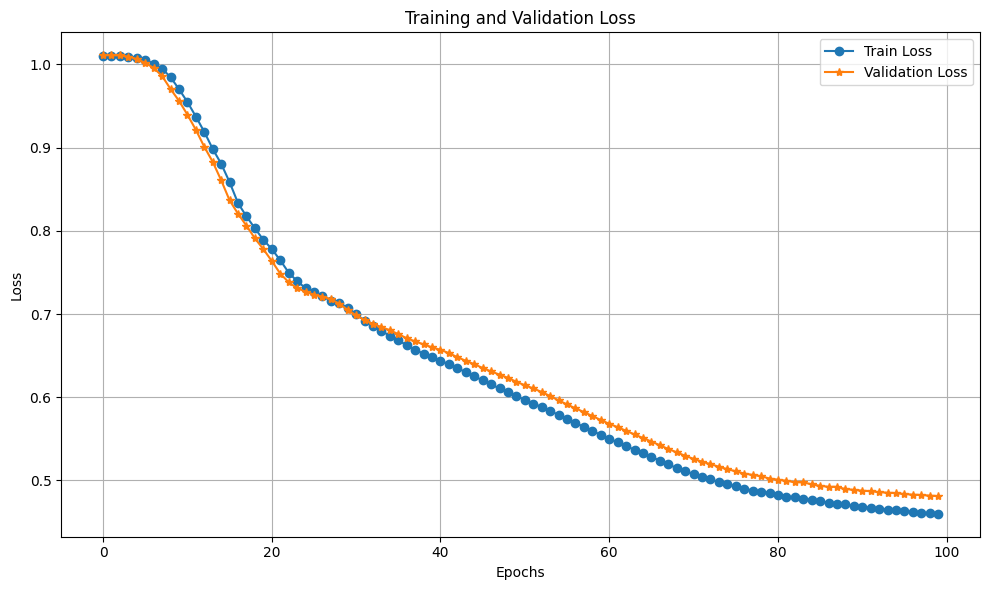

In [21]:
# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), final_train_loss, label="Train Loss", marker='o')
plt.plot(range(epochs), final_val_loss, label="Validation Loss", marker='*')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **3.3.2. Inference**

In this section, we will show how we can recommend top N movies for a specific user based on the trained GNN. Since we already have a test set edges. We will use this to demonstrate the inference. We will do the following:

1. Extract test edges: With the test_mask, obtain the edges that belong to the test set.
2. Predict ratings: For each of these test edges, use the trained GNN to predict a rating.
3. Map to original data: Using the movie_mapping and user_mapping from the GraphDataPreparation class, convert the predicted edges back to the original movie and user IDs.
4. Get movie names: For the mapped movie IDs, fetch the actual movie names.
5. To get the top N recommended movies for a particular user, we will sort the movies based on the predicted ratings and then pick the top N movies for the user.


Below we will implement two functions to do the above steps for us.

In [22]:
# Using the test_mask, get the edges corresponding to the test set
test_edge_senders = graph.senders[test_mask.squeeze()]
test_edge_receivers = graph.receivers[test_mask.squeeze()] - len(data.user_mapping)

In [23]:
# Predict the ratings using the trained model
_, logits = evaluate_step(final_state, graph, labels=graph.edges, mask=test_mask)
predicted_ratings = logits[test_mask]

In [24]:
# get back the original user and movie IDs
reverse_user_mapping = {v: k for k, v in data.user_mapping.items()}
reverse_movie_mapping = {v: k for k, v in data.movie_mapping.items()}

In [25]:
# Get original user and movie ids for lookup
original_user_ids = np.array([reverse_user_mapping[v] for v in test_edge_senders]).astype(str)
original_movie_ids = np.array([reverse_movie_mapping[v] for v in test_edge_receivers]).astype(str)

In [26]:
# Get movie names using the original movie_ids
movie_title = movies_df.set_index('movie_id').loc[original_movie_ids, 'movie_title'].values

# Create a DataFrame with the results
predicted_ratings_df = pd.DataFrame({
    'user_id': original_user_ids,
    'movie_name': movie_title,
    'predicted_rating': np.round(predicted_ratings, 3)
})
predicted_ratings_df.head()

,user_id,movie_name,predicted_rating
0,710,Aladdin (1992),3.812
1,797,Jungle2Jungle (1997),3.120
2,188,"Man Without a Face, The (1993)",3.531
3,91,GoodFellas (1990),3.935
4,195,Snow White and the Seven Dwarfs (1937),1.000


In [27]:
# Get the top N recommended movies for a user.

user_id = "600"
N = 10

top_movies = predicted_ratings_df[predicted_ratings_df['user_id'] == user_id].sort_values(by='predicted_rating', ascending=False).head(N)
top_N = top_movies['movie_name'].tolist()

print(f'Top {len(top_N)} movies recommended for user ID: {user_id} are: ')

for number, movie_title in enumerate(top_N):
    print(f'{number}: {movie_title}')

Top 10 movies recommended for user ID: 600 are: 
0: Specialist, The (1994)
1: Full Monty, The (1997)
2: Demolition Man (1993)
3: Young Guns II (1990)
4: Pulp Fiction (1994)
5: Quick and the Dead, The (1995)
6: Romeo Is Bleeding (1993)
7: Die Hard: With a Vengeance (1995)
8: Star Trek IV: The Voyage Home (1986)
9: Die Hard 2 (1990)
